## [Predicting Stroke Likelihood based on Demographic, Health History, and Lifestyle Metrics]("https://www.kaggle.com/datasets/teamincribo/stroke-prediction/data")

   ### Introduction:   
Our project will focus on stroke likeliness prediction using varying metrics that can assess stroke factors in a patient. [A stroke is a medical condition in which blood flow to the brain is disrupted in some way]("https://www.cdc.gov/stroke/about.htm#:~:text=A%20stroke%2C%20sometimes%20called%20a,term%20disability%2C%20or%20even%20death."). There are two ways a stroke can occur: arteries within the brain rupture (hemorrhagic) or are blocked by a blood clot (ischemic). Strokes can cause brain damage or in severe cases, death. [Stroke risk factors]("https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113") include arterial plaque buildup and hypertension. Lifestyle metrics and genetic history can also be important determinants in stroke likelihood.   
  
Through our project, we aim to answer the question *“How can we predict stroke likelihood given predictors of lifestyle, socioeconomic demographics, and health?”* 
  
We will use a synthetically generated dataset with stroke prediction metrics, called “[stroke_prediction.csv]("https://raw.githubusercontent.com/incribo-inc/stroke_prediction/main/stroke_prediction_dataset.csv")”. Each patient observation contains a range of stroke metrics and the diagnosis of stroke.  Some variables included (but are not limited to) in this data are Age, Gender, Hypertension, Heart Disease, Average Glucose Level, Body Mass Index (BMI), etc. More than 15,000 records included in this dataset, therefore there is enough standing data to use in a KNN classification algorithm for prediction.    
fy key areas for improvement with preventative health. An algorithm that can be developed on this data can also be useful for identifying high-risk populations and starting preventative health intervention early.

### Methods:    
We will create 3 KNN-classification prediction models using stroke metrics to predict the likelihood of a stroke. The first will use demographic predictors of age, gender and family stroke history. The second will use health predictors of heart disease, stress levels and hypertension, and the third will use lifestyle predictors of alcohol consumption, physical activity and dietary habits.   
  
We will split the dataset into a training set and testing set, and use cross-validation to determine the best K-value for each of the 3 models. Scatter plots will be used to visualize each prediction model. After training the knn-algorithm, we will evaluate the three prediction models using the testing set. We will cross-compare the three models to determine which predicts stroke likelihood with the most confidence.   
  
As a further investigation, we will use all three prediction models to evaluate a random sample patient with observations from all three predictor set metrics. This simulates a real-world application where an individual can be analyzed holistically through multiple facets. 

### Expected Outcomes and Significance:  
We hypothesize the health metrics category predictors will have the highest accuracy to be used as a prediction model to find out a patient's stroke history status. Literature suggests that hypertension and heart disease specifically are well-known comorbidities for stroke.  
  
These findings can be essential in clinical and public health applications. By creating a model that assesses predictors of stroke metrics, public health officials can identify key areas for improvement with preventative health. An algorithm that can be developed on this data can also be useful for identifying high-risk populations and starting preventative health intervention early.  
  
A future question that can be addressed following this algorithm if there other demographic, health, or lifestyle factors that were not considered in this study but might also influence stroke risk?

### Cleaning and Wrangling:

In [1]:
# CZ - Run cell before starting workspace - loads necessary packages
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [1]:
# CZ - upload and read the data file from raw github hosted source
url <- "https://raw.githubusercontent.com/incribo-inc/stroke_prediction/main/stroke_prediction_dataset.csv"
stroke <- read.csv(url)

ERROR: Error in read_csv(url): could not find function "read_csv"


In [3]:
##### CZ commit start - wrangled data, did initial tidying, visualizations

# set seed - don't change!
set.seed(1234)

# wrangling - selects cols for prediction
stroke_selected <- stroke |>
    select(Age, Gender, Hypertension, Heart.Disease, Alcohol.Intake, 
           Physical.Activity, Family.History.of.Stroke,
           Dietary.Habits, Stress.Levels, Diagnosis)

# rename columns
stroke_renamed <- stroke_selected |>
    rename(age = Age,
           gender = Gender,
           hypertension = Hypertension,
           heart_disease = Heart.Disease,
           alcohol_intake = Alcohol.Intake,
           activity = Physical.Activity,
           family_history = Family.History.of.Stroke,
           diet = Dietary.Habits,
           stress = Stress.Levels,
           diagnosis = Diagnosis)


# wrangle categorical columns
# gender was commented out for the purpose of clear labels during visualization - we will convert to numeric when using KNN

# stroke_renamed$gender <- as.numeric(factor(stroke_renamed$gender,
                                          # levels = c("Male", "Female"),
                                          # labels = c(1, 0)))


stroke_renamed$alcohol_intake <- as.numeric(factor(stroke_renamed$alcohol_intake,
                                           levels = c("Never", "Rarely", "Social Drinker", "Frequent Drinker"),
                                           labels = c(0, 1, 2, 3)))

stroke_renamed$family_history <- as.numeric(factor(stroke_renamed$family_history,
                                           levels = c("Yes", "No"),
                                           labels = c(1, 0)))
stroke_renamed$activity <- as.numeric(factor(stroke_renamed$activity,
                                             levels = c("Moderate", "Low", "High"),
                                             labels = c(2, 1, 3)))            

# stroke_renamed

In [4]:
# split data
# we are using 9 predictors, so 2/3 = 67% data used as training, 1/3 = 33% predicting
pre_split_stroke <- stroke

stroke_split <- initial_split(stroke_renamed, prop = 0.67, strata = diagnosis)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

 stroke_train
# stroke_test

,age,gender,hypertension,heart_disease,alcohol_intake,activity,family_history,diet,stress,diagnosis
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
4,73,Male,0,0,4,1,2,Paleo,5.35,No Stroke
10,82,Male,0,0,2,3,1,Non-Vegetarian,8.39,No Stroke
11,41,Male,0,1,4,2,1,Pescatarian,1.56,No Stroke
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
14986,75,Male,1,1,4,1,2,Gluten-Free,0.23,Stroke
14993,81,Female,1,1,2,1,2,Non-Vegetarian,5.49,Stroke
15000,64,Female,0,0,2,1,2,Vegan,4.57,Stroke


In [5]:
# summarizing observations per class, means of variables, missing data counts for diagnosed strokes

stroke_summary <- stroke_train |>
    group_by(diagnosis) |>
    summarize(
        count = n(),
        mean_age = mean(age, na.rm = TRUE),
        mean_gender = mean(gender, na.rm = TRUE),
        mean_hypertension = mean(hypertension, na.rm = TRUE),
        mean_heart_disease = mean(heart_disease, na.rm = TRUE),
        mean_alcohol = mean(alcohol_intake, na.rm = TRUE),
        mean_activity = mean(activity, na.rm = TRUE),
        mean_famhist = mean(family_history, na.rm = TRUE),
        mean_diet = mean(diet, na.rm = TRUE),
        mean_stress = mean(stress, na.rm = TRUE),
        missing_age = sum(is.na(age)),
        missing_gender = sum(is.na(gender)),
        missing_hypertension = sum(is.na(hypertension)),
        missing_heart_disease = sum(is.na(heart_disease)),
        missing_alcohol = sum(is.na(alcohol_intake)),
        missing_activity = sum(is.na(activity)),
        missing_famhist = sum(is.na(family_history)),
        missing_diet = sum(is.na(diet)),
        missing_stress = sum(is.na(stress)),
        )

# after printing the above table, there were no missing values for any columns
# additionally
# for clarity, these columns were omitted

stroke_summary <- stroke_summary |>
    select(mean_age, mean_gender, mean_hypertension, 
           mean_heart_disease, mean_alcohol, mean_activity,
           mean_famhist, mean_diet, mean_stress)

stroke_summary
        
      

Warning message:
“There were 4 warnings in `summarize()`.
The first warning was:
ℹ In argument: `mean_gender = mean(gender, na.rm = TRUE)`.
ℹ In group 1: `diagnosis = "No Stroke"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


mean_age,mean_gender,mean_hypertension,mean_heart_disease,mean_alcohol,mean_activity,mean_famhist,mean_diet,mean_stress
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.0759,NA,0.2471264,0.4992073,2.511296,2.007729,1.487515,NA,5.076141
54.3306,NA,0.2448531,0.4983010,2.495503,2.000000,1.502499,NA,4.970406


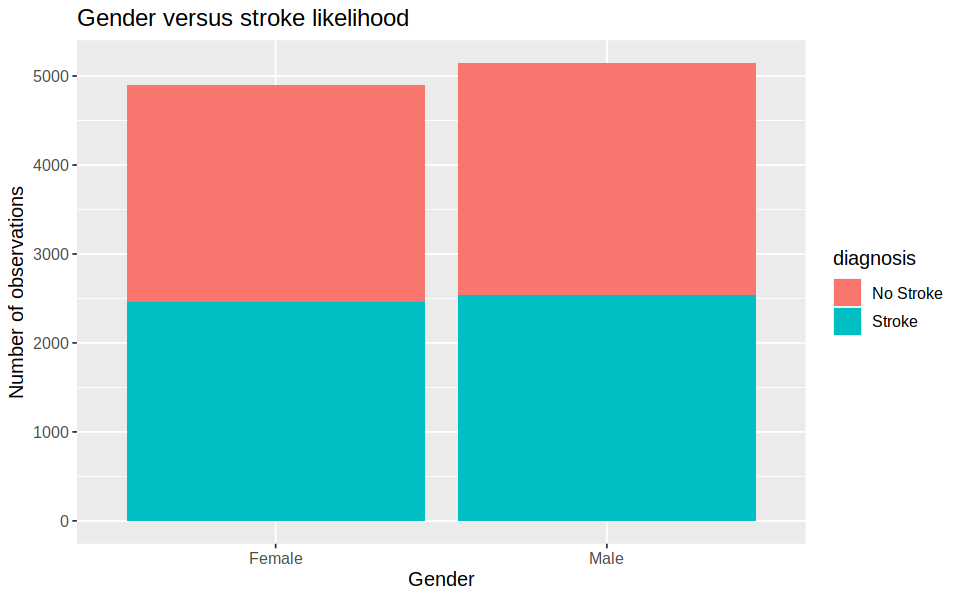

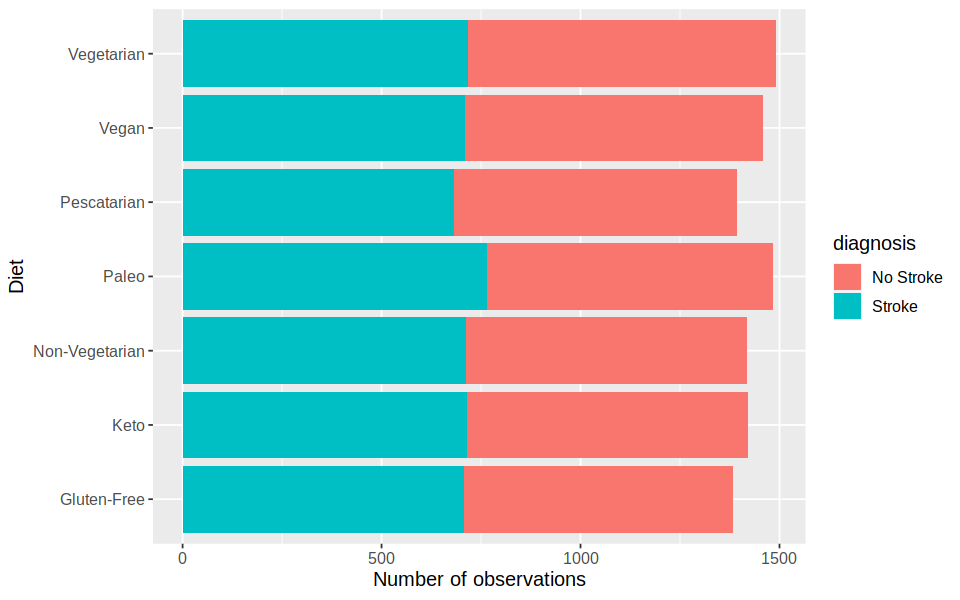

In [6]:
options(repr.plot.width = 8, repr.plot.height = 5) 

# visualize data for gender and stroke likelihood
gender_viz <- stroke_train |>
    ggplot(aes(x = gender)) +
    geom_bar(aes(fill = diagnosis)) +
    xlab("Gender") +
    ylab("Number of observations") +
    theme(text = element_text(size=12)) +
    labs(color = "Diagnosis of stroke") +
    ggtitle("Gender versus stroke likelihood")

gender_viz

# visualize data for diet and stroke likelihood
diet_viz <- stroke_train |>
    ggplot(aes(y = diet)) +
    geom_bar(aes(fill = diagnosis)) +
    xlab("Number of observations") +
    ylab("Diet") +
    theme(text = element_text(size=12)) +
    labs(color = "Diagnosis of stroke")

diet_viz

#### CZ commit end


## Sources

* Prediction Dataset: Stroke Prediction  
https://www.kaggle.com/datasets/teamincribo/stroke-prediction/data  

* Stroke Information:
https://www.cdc.gov/stroke/about.htm#:~:text=A%20stroke%2C%20sometimes%20called%20a,term%20disability%2C%20or%20even%20death

* Stroke Risk Factors:  
https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113